In [ ]:
!pip install yfinance

In [267]:
import yfinance as yf
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import requests, yfinance as yf

In [297]:
def get_tickers(name, n=5):
    url = "https://query2.finance.yahoo.com/v1/finance/search"
    headers = {"User-Agent": "Mozilla/5.0"}
    params = {"q": name, "quotesCount": n}
    r = requests.get(url, headers=headers, params=params)
    try:
        results = r.json()["quotes"]
        return [(i+1, x["symbol"], x.get("shortname", "No Name")) for i, x in enumerate(results)]
    except:
        print("❌ Error: Could not fetch ticker info.")
        return []
name = input("Enter company name: ").strip()
candidates = get_tickers(name)
if not candidates:
    exit()
for i, sym, desc in candidates:
    print(f"{i}. {sym:10} → {desc}")
choice = int(input("Pick ticker (1-5): ")) - 1
ticker = candidates[choice][1]
print(f"\n📈 Fetching data for {ticker} ...")


Enter company name: nifty
1. ^NSEI      → NIFTY 50
2. ^NSEBANK   → NIFTY BANK
3. NIFTYBEES.NS → NIP IND ETF NIFTY BEES
4. ^CNXIT     → NIFTY IT
5. 453870.KS  → TIGER India Nifty 50
Pick ticker (1-5): 1

📈 Fetching data for ^NSEI ...


In [ ]:
import yfinance as yf
print("Choose a time frame:\n1: Days\n2: Weeks\n3: Months\n4: Years\n5: Hours\n6: Seconds\n7: Minutes")
time_option = input("Enter time frame number (1-7): ").strip()

if time_option == '1':
    units = int(input("Enter the number of days: "))
    time_frame = f"{units}d"
elif time_option == '2':
    units = int(input("Enter the number of weeks: "))
    time_frame = f"{units}wk"
elif time_option == '3':
    units = int(input("Enter the number of months: "))
    time_frame = f"{units}mo"
elif time_option == '4':
    units = int(input("Enter the number of years: "))
    time_frame = f"{units}y"
elif time_option == '5':
    units = int(input("Enter the number of hours: "))
    time_frame = f"{units}h"
elif time_option == '6':
    units = int(input("Enter the number of seconds: "))
    time_frame = f"{units}s"
elif time_option == '7':
    units = int(input("Enter the number of minutes: "))
    time_frame = f"{units}m"
else:
    print("❌ Invalid time frame option.")
    exit()

lag_days = int(input("Enter the lag time units for LSTM trend prediction: "))
batch_size = int(input("Enter the batch size for LSTM: "))
epochs = int(input("Enter the number of epochs for LSTM: "))
alpha = float(input("Enter the alpha parameter for focal loss (LSTM): "))
gamma = float(input("Enter the gamma parameter for focal loss (LSTM): "))

lr = float(input("Enter the learning rate for the boosting algorithm (closing price): "))
split_ratio = float(input("Enter the train-test split ratio (0 to 1) for boosting model: "))
model_num = int(input("Enter the number of boosting models (e.g., 50): "))
model_choice = int(input("Enter 0 for Linear Regression or 1 for Decision Tree for boosting model: "))

In [268]:
ticker_symbol = ticker
stock = yf.Ticker(ticker_symbol)
hist_data= stock.history(period="max", interval=time_frame)
df=pd.DataFrame(hist_data)
print(df.shape)

(6198, 7)


In [269]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [270]:
df['netgain'] = df['Close'] - df['Open']
df['trend'] = (df['netgain'] > 0).astype(int)
df['target']=df["trend"].shift(-1)
df.drop(["Volume","Dividends","Stock Splits"],inplace=True ,axis=1)

In [272]:
df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,netgain,trend,target
Datetime,,,,,,,
2025-06-25 15:19:00+05:30,25244.400391,25246.900391,25242.349609,25244.849609,0.449219,1,0.0
2025-06-25 15:21:00+05:30,25244.800781,25246.449219,25241.400391,25242.000000,-2.800781,0,0.0
2025-06-25 15:23:00+05:30,25242.000000,25244.400391,25239.000000,25241.199219,-0.800781,0,1.0
2025-06-25 15:25:00+05:30,25241.099609,25244.949219,25235.500000,25243.349609,2.250000,1,1.0
2025-06-25 15:27:00+05:30,25244.150391,25247.949219,25239.900391,25244.250000,0.099609,1,0.0


In [273]:
cols_to_scale = ['Close', 'Open', 'High', 'Low']
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
lag_days = lag_days
for lag in range(1, lag_days + 1):
    for feature in cols_to_scale:
        df[f'{feature}(t-{lag})'] = df[feature].shift(lag)

In [274]:
def focal_loss(alpha=0.5, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        return K.mean(weight * cross_entropy)
    return loss


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 8, 128)         │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 8, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,465 (509.63 KB)

 Trainable params: 130,465 (509.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5064 - loss: 0.0958 - val_accuracy: 0.5066 - val_loss: 0.0867
Epoch 2/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.5198 - loss: 0.0952 - val_accuracy: 0.4783 - val_loss: 0.0867
Epoch 3/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5080 - loss: 0.0951 - val_accuracy: 0.4783 - val_loss: 0.0872
Epoch 4/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5041 - loss: 0.0955 - val_accuracy: 0.4834 - val_loss: 0.0867
Epoch 5/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5182 - loss: 0.0955 - val_accuracy: 0.5217 - val_loss: 0.0865
Epoch 6/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5131 - loss: 0.0954 - val_accuracy: 0.4783 - val_loss: 0.0869
Epoch 7/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5170 - loss: 0.0955 - val_accuracy: 0.5207 - val_loss: 0.0866
Epoch 8/20
496/496 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4982 - loss: 0.0955 - val_a

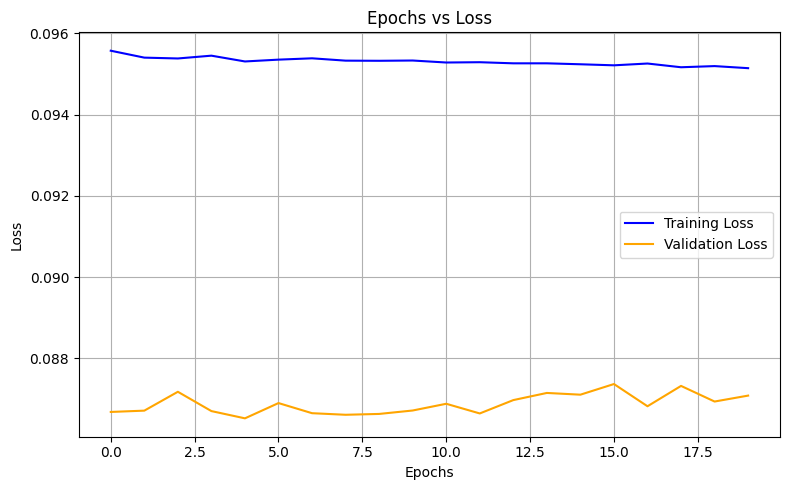

In [275]:
feature_list = ['Close', 'Open', 'High', 'Low', 'trend']

for lag in range(1, lag_days + 1):
    df[f'trend(t-{lag})'] = df['trend'].shift(lag)
df=df.dropna()

input_features = []
for lag in range(lag_days, 0, -1):
    input_features.extend([f'{feature}(t-{lag})' for feature in feature_list])

input_features.extend(feature_list)
X = df[input_features].values
y = df['target'].values
X = X.reshape((X.shape[0], lag_days+1, len(feature_list)))

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(lag_days+1, len(feature_list))))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=focal_loss(alpha=alpha,gamma=gamma), optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)


plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



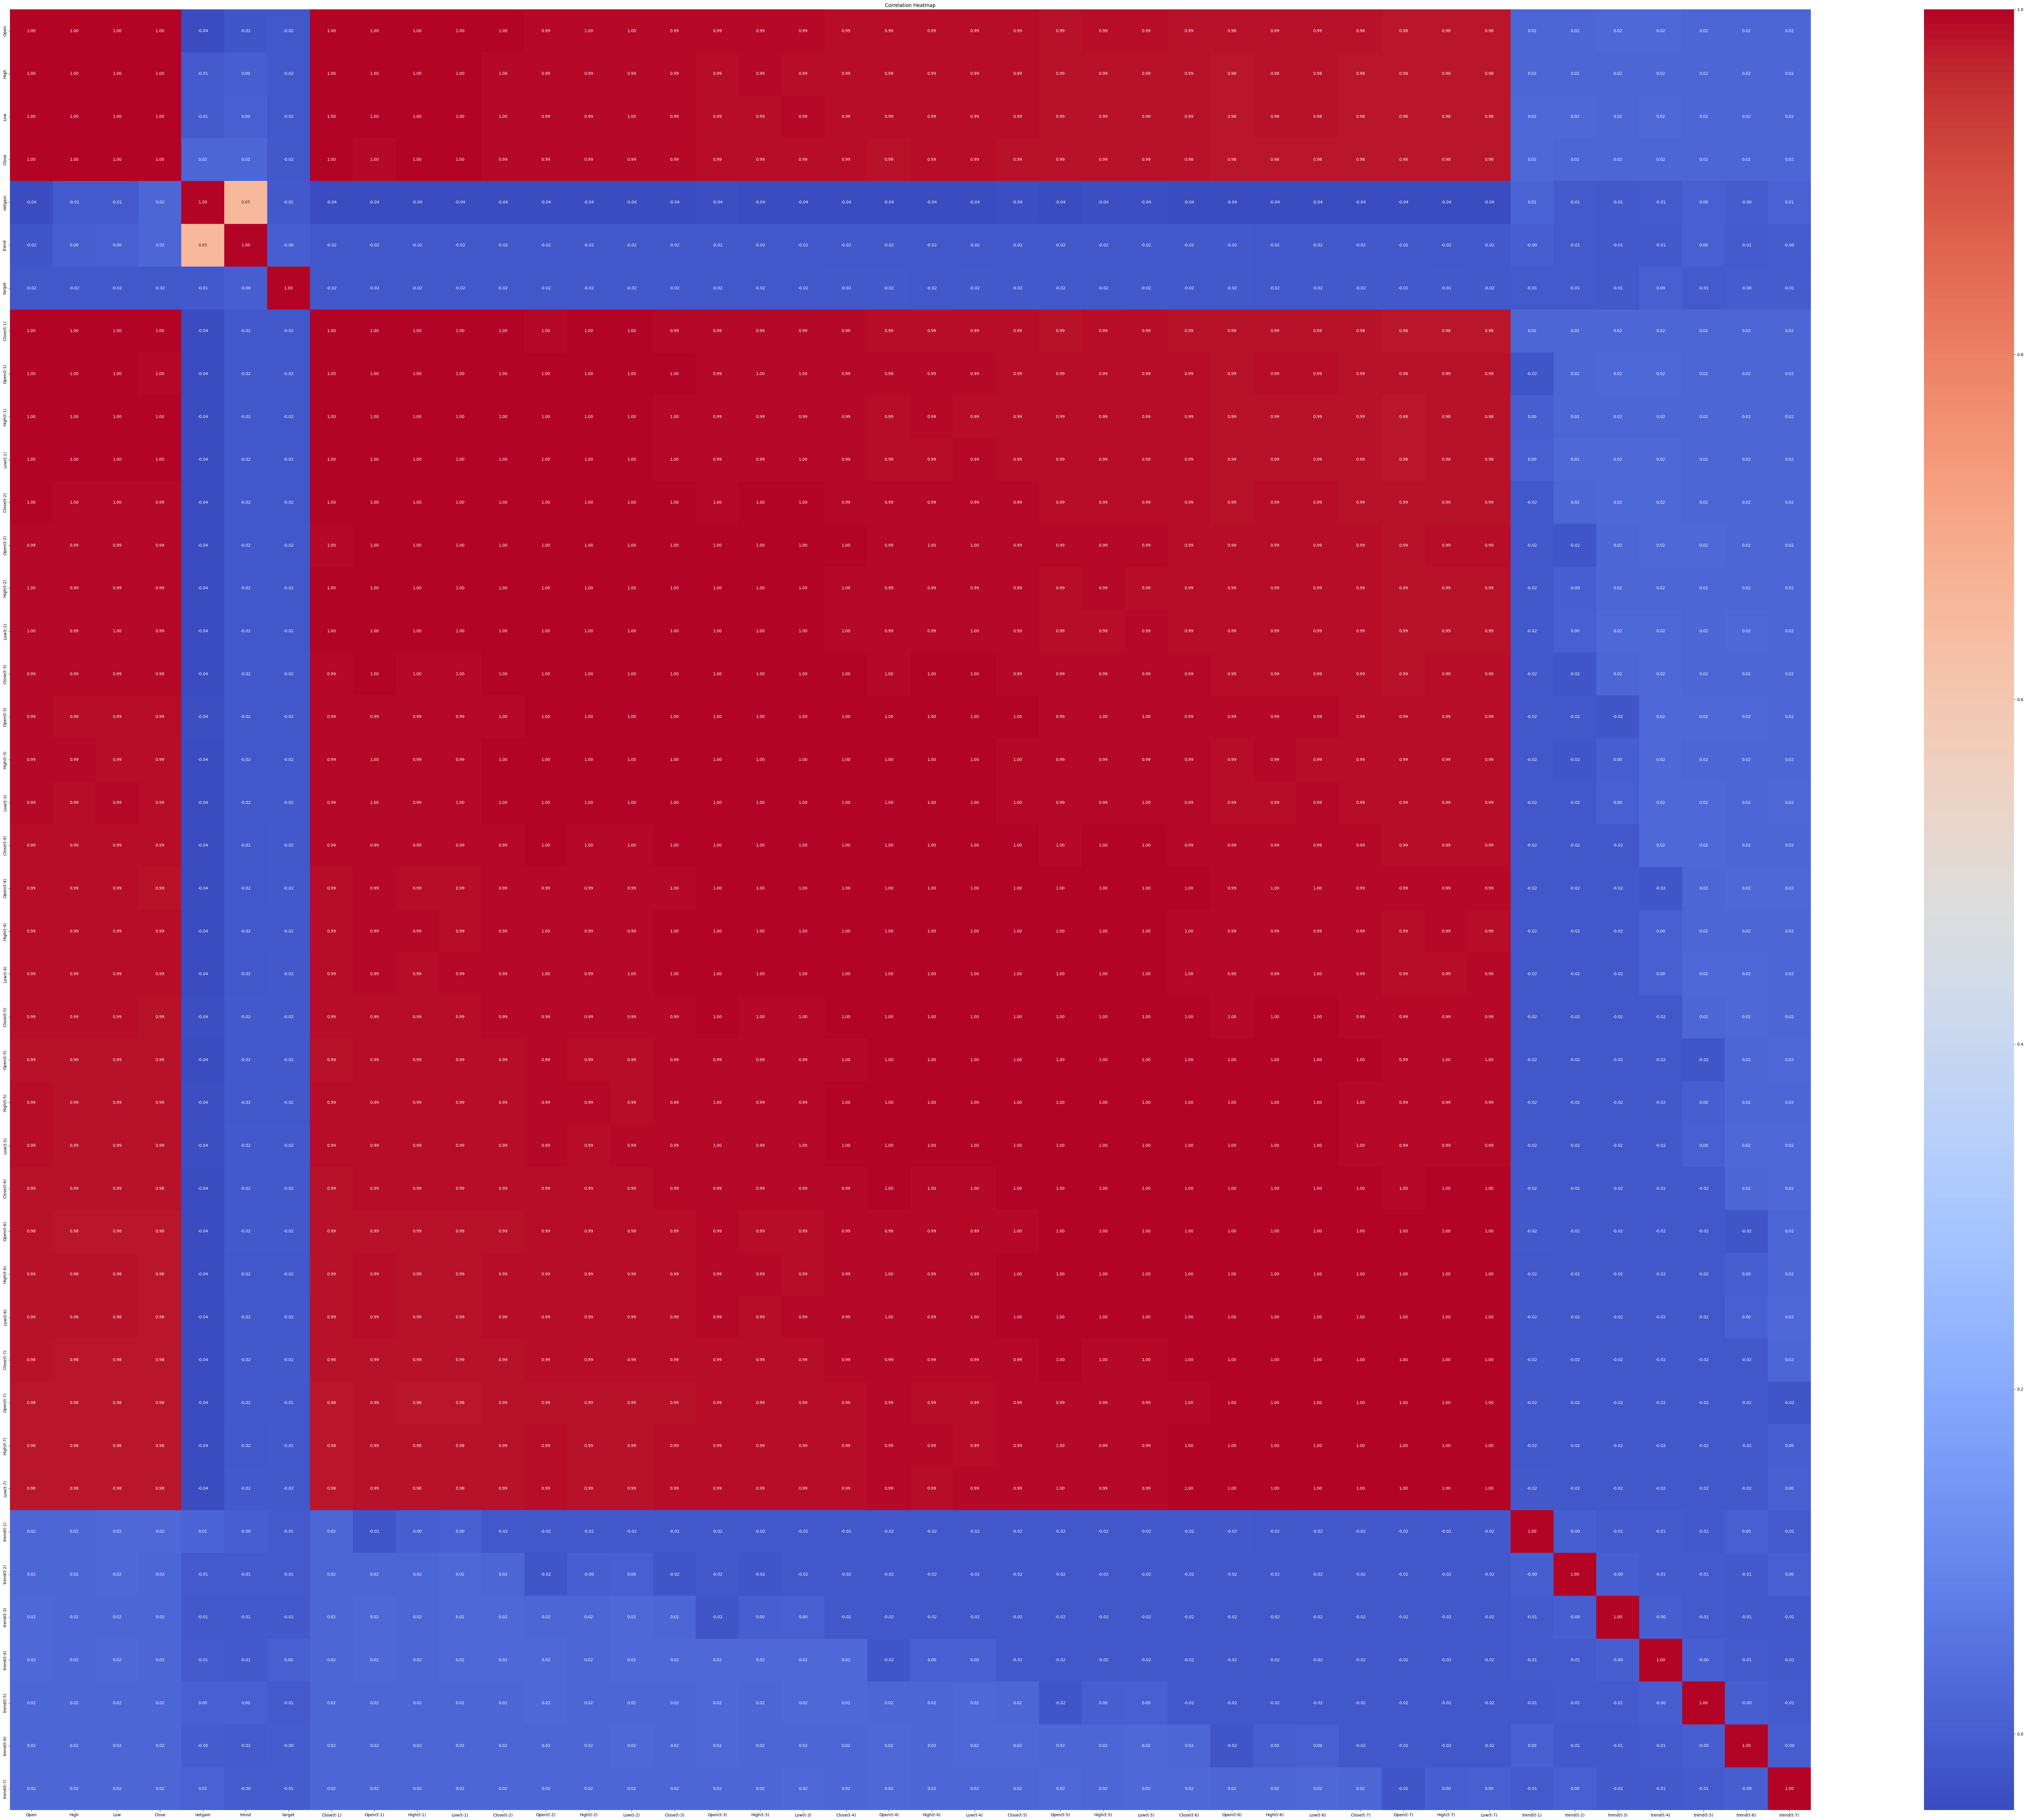

In [276]:

corr = df.corr()
plt.figure(figsize=(100, 80))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)

plt.title('Correlation Heatmap')
plt.show()


In [277]:
y_scores = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
J = tpr - fpr
best_idx = J.argmax()
best_threshold = thresholds[best_idx]
print(f"Best threshold: {best_threshold}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Best threshold: 0.5043184757232666


In [278]:

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Confusion Matrix:
[[583  12]
 [622  21]]


In [279]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > best_threshold).astype(int)
acc = accuracy_score(y_test, y_pred_binary)
print("Test Accuracy:", acc)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test Accuracy: 0.4878836833602585


In [280]:
y_pred = model.predict(X_test).ravel()
print("Min:", y_pred.min())
print("Max:", y_pred.max())

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Min: 0.44883218
Max: 0.50674504


In [281]:
ticker_symbol =ticker
stock = yf.Ticker(ticker_symbol)
hist_data= stock.history(period="max", interval=time_frame)
df_f=pd.DataFrame(hist_data)
print(df_f.shape)

(6198, 7)


In [287]:
df_f["target"]=(df_f["Close"].shift(-1))
df_f["volat"]=df_f["High"]-df_f["Low"]
df_f["net_gain"]=df_f["Close"]-df_f["Open"]

In [288]:
df_f.dropna(inplace=True)

In [289]:
test_data = df_f.iloc[int((split_ratio)*len(df_f)):].copy()
df_f = df_f.iloc[:int((split_ratio)*len(df_f))].copy()

Mean Squared Error (Train): 181.3961
R2 Score (Train): 0.9929
Mean Squared Error (Test): 167.2731
R2 Score (Test): 0.9948


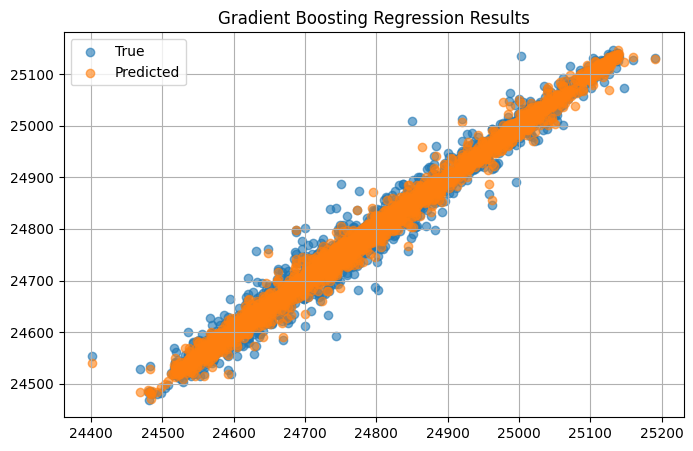

In [290]:
#custom gradient boosting
lr = lr
m = []
no_of_models = model_num

df_f["y_pred"] =np.mean(df_f["target"])

for i in range(1, no_of_models):
    df_f["res"] = df_f["target"] - df_f["y_pred"]
    if model_name==0:
      model=LinearRegression()
    else:
      model=DecisionTreeRegressor()
    model.fit(df_f[["Close","Open","volat","net_gain"]], df_f["res"])
    df_f["y_pred"] += lr * model.predict(df_f[["Close","Open","volat","net_gain"]])
    m.append(model)


mse = mean_squared_error(df_f["target"], df_f["y_pred"])
r2 = r2_score(df_f["target"], df_f["y_pred"])
print(f"Mean Squared Error (Train): {mse:.4f}")
print(f"R2 Score (Train): {r2:.4f}")

test_data["y_pred_test"] =np.mean(df_f["target"])
for model in m:
    test_data["y_pred_test"] += lr * model.predict(test_data[["Close","Open","volat","net_gain"]])

mse_test = mean_squared_error(test_data["target"], test_data["y_pred_test"])
r2_test = r2_score(test_data["target"], test_data["y_pred_test"])
print(f"Mean Squared Error (Test): {mse_test:.4f}")
print(f"R2 Score (Test): {r2_test:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(df_f["Open"], df_f["target"], label="True", alpha=0.6)
plt.scatter(df_f["Open"], df_f["y_pred"], label="Predicted", alpha=0.6)
plt.legend()
plt.grid(True)
plt.title("Gradient Boosting Regression Results")
plt.show()


In [291]:
df_f.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target,volat,net_gain,y_pred,res
Datetime,,,,,,,,,,,,
2025-06-10 09:45:00+05:30,25108.199219,25117.500000,25104.250000,25104.699219,0,0.0,0.0,25125.300781,13.250000,-3.500000,25103.574028,21.768926
2025-06-10 09:47:00+05:30,25105.849609,25125.599609,25103.599609,25125.300781,0,0.0,0.0,25126.300781,22.000000,19.451172,25123.906809,2.438960
2025-06-10 09:49:00+05:30,25125.750000,25128.300781,25120.849609,25126.300781,0,0.0,0.0,25128.900391,7.451172,0.550781,25125.250974,3.694591
2025-06-10 09:51:00+05:30,25126.250000,25142.000000,25120.099609,25128.900391,0,0.0,0.0,25126.449219,21.900391,2.650391,25127.450888,-0.956190
2025-06-10 09:53:00+05:30,25128.250000,25131.349609,25124.199219,25126.449219,0,0.0,0.0,25130.650391,7.150391,-1.800781,25125.400987,5.294599


In [292]:
assert "y_pred_test" in test_data.columns, "y_pred_test missing!"
test_data["res"] = test_data["target"] - test_data["y_pred_test"]

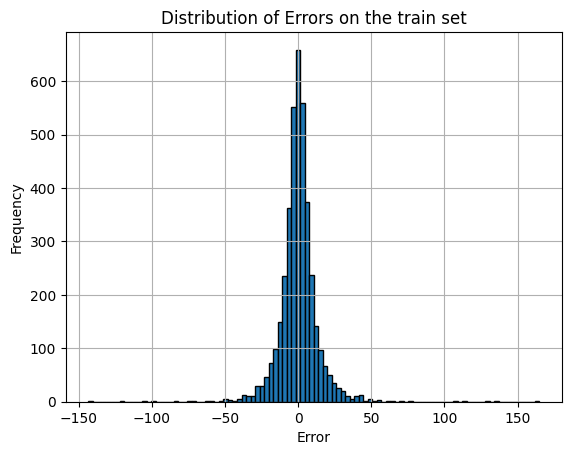

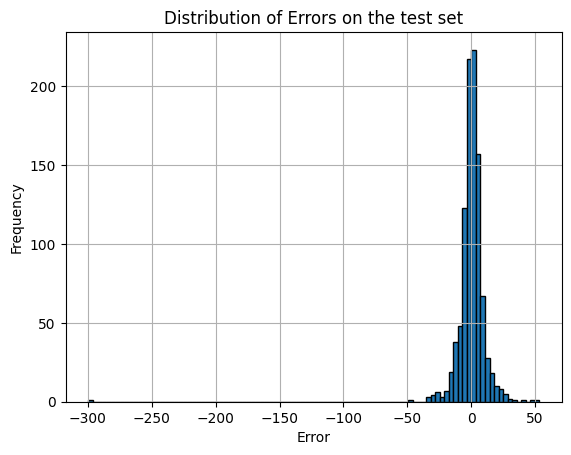

In [293]:
plt.hist(df_f["res"], bins=100, edgecolor='black')
plt.title("Distribution of Errors on the train set")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.hist(test_data["res"], bins=100, edgecolor='black')
plt.title("Distribution of Errors on the test set")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [294]:
x=np.mean(abs(test_data["res"]))
print(f"mean aboslute error from actual and precdicted value {x}")

np.float64(6.299763500612016)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

data = df_f["error"].dropna().values


distributions = ['norm', 'expon', 'gamma', 'beta', 'lognorm', 'weibull_min', 'weibull_max',
                 't', 'laplace', 'cauchy', 'gennorm', 'skewnorm']

results = []

for dist_name in distributions:
    dist = getattr(stats, dist_name)
    try:
        params = dist.fit(data)
        log_likelihood = np.sum(dist.logpdf(data, *params))
        aic = 2 * len(params) - 2 * log_likelihood
        results.append((dist_name, aic, params))
    except Exception as e:
        print(f"{dist_name} failed: {e}")

results.sort(key=lambda x: x[1])
for dist_name, aic, params in results:
    print(f"{dist_name}: AIC = {aic:.2f}")
best_dist_name, _, best_params = results[0]
best_dist = getattr(stats, best_dist_name)
x = np.linspace(min(data), max(data), 100)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.figure(figsize=(8,5))
plt.hist(data, bins=30, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_fitted, 'r-', label=f'{best_dist_name} fit')
plt.legend()
plt.title(f'Best PDF Fit: {best_dist_name}')
plt.grid(True)
plt.show()